# Figure for Ensemble Sizes Result
## Initialisation

In [1]:
import json
import numpy as np
import os
import pandas as pd
from scipy import stats
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib import cm

import initialise
import common

In [2]:
SCENARIOS = ['out-of-site', 'within-site']
samples_file = os.path.join(common.DATASETS_DIR, 'samples_365days.csv')
model_dir1 = os.path.join(common.MODELS_DIR, f'{SCENARIOS[0]}_models')
model_dir2 = os.path.join(common.MODELS_DIR, f'{SCENARIOS[1]}_models')
precision = 2

In [3]:
with open(os.path.join(model_dir2, 'model_params.json'), 'r') as f:
    model_params = json.load(f)

In [4]:
samples1 = pd.read_csv(samples_file, index_col=0)
temp_predict = pd.read_csv(os.path.join(model_dir2, f'ensemble{common.ENSEMBLE_SIZE}_{common.ANALYSIS_MODEL}.csv'), index_col=0)
samples2 = samples1.reindex(temp_predict.index)

## Get the predictions and summary statistics

In [5]:
def get_results(model_dir, samples):
    predict = []
    all_stats = []
    # Load predictions and statistics files
    for num, test in enumerate(common.ENSEMBLE_NAMES):
        if num == 0:
            file_name = f'single_{common.ANALYSIS_MODEL}.csv'
            stats_fname = f"single_stats.csv"
        else:
            file_name = f"ensemble{common.ENSEMBLE_SIZES[num]:02}_{common.ANALYSIS_MODEL}.csv"
            stats_fname = f"ensemble{common.ENSEMBLE_SIZES[num]:02}_stats.csv"
        predict.append(pd.read_csv(os.path.join(model_dir, file_name), index_col=0).loc[samples.index])
        all_stats.append(pd.read_csv(os.path.join(model_dir, stats_fname), index_col=(0,1)).T[common.ANALYSIS_MODEL])

    # Compute the means and confidence intervals
    means = [stats_.mean() for stats_ in all_stats]
    ci_dict = {}
    for n, t in enumerate(all_stats):
        ci = stats.t.interval(0.95, t.shape[1]-1, loc=np.mean(t), scale=stats.sem(t))
        ci = ((ci[1] - ci[0]) / 2).round(precision)
        ci_dict[common.ENSEMBLE_NAMES[n]] = pd.DataFrame([means[n].array, ci], index=['mean', 'ci'], columns=t.columns)

    # Create dataframe for means/CIs
    df_list = []
    for num, test in enumerate(common.ENSEMBLE_NAMES):
        df_dict={}
        df_dict.update(ci_dict[test].RMSE.round(precision).add_prefix('RMSE_').to_dict())
        df_dict['Pred_var'] = round(predict[num].var(axis=1).mean(), precision)
        df_dict.update(ci_dict[test].ubRMSE.round(precision).add_prefix('ubRMSE_').to_dict())
        df_dict.update(ci_dict[test].Bias.round(precision).add_prefix('Bias_').to_dict())
        df_dict.update(ci_dict[test].R2.round(precision).add_prefix('R2_').to_dict())
        df_list.append(df_dict)
    ci_df = pd.DataFrame(df_list, index=common.ENSEMBLE_NAMES)

    return ci_df, all_stats

## Results Summary
### Out-of-site Ensembles

In [6]:
ci_df1, all_stats1 = get_results(model_dir1, samples1)
ci_df1

,RMSE_mean,RMSE_ci,Pred_var,ubRMSE_mean,ubRMSE_ci,Bias_mean,Bias_ci,R2_mean,R2_ci
Single model,26.75,0.07,76.19,26.73,0.07,0.62,0.36,0.48,0.0
Ensemble 5,25.60,0.02,13.83,25.59,0.02,0.63,0.19,0.53,0.0
Ensemble 10,25.44,0.02,6.23,25.43,0.02,0.63,0.11,0.53,0.0
Ensemble 15,25.39,0.02,3.54,25.38,0.02,0.61,0.09,0.53,0.0
Ensemble 20,25.36,0.01,2.22,25.36,0.01,0.59,0.06,0.54,0.0
Ensemble 25,25.34,0.01,1.51,25.34,0.01,0.61,0.05,0.54,0.0


### Within-site Ensembles

In [7]:
ci_df2, all_stats2 = get_results(model_dir2, samples2)
ci_df2

,RMSE_mean,RMSE_ci,Pred_var,ubRMSE_mean,ubRMSE_ci,Bias_mean,Bias_ci,R2_mean,R2_ci
Single model,22.62,0.08,80.91,22.61,0.08,0.19,0.29,0.64,0.0
Ensemble 5,21.13,0.03,14.71,21.12,0.03,0.20,0.13,0.69,0.0
Ensemble 10,20.96,0.02,6.47,20.96,0.02,0.22,0.09,0.69,0.0
Ensemble 15,20.89,0.02,3.75,20.89,0.02,0.21,0.06,0.70,0.0
Ensemble 20,20.87,0.01,2.42,20.87,0.01,0.22,0.05,0.70,0.0
Ensemble 25,20.84,0.01,1.62,20.83,0.01,0.18,0.04,0.70,0.0


## Ensembles Figure

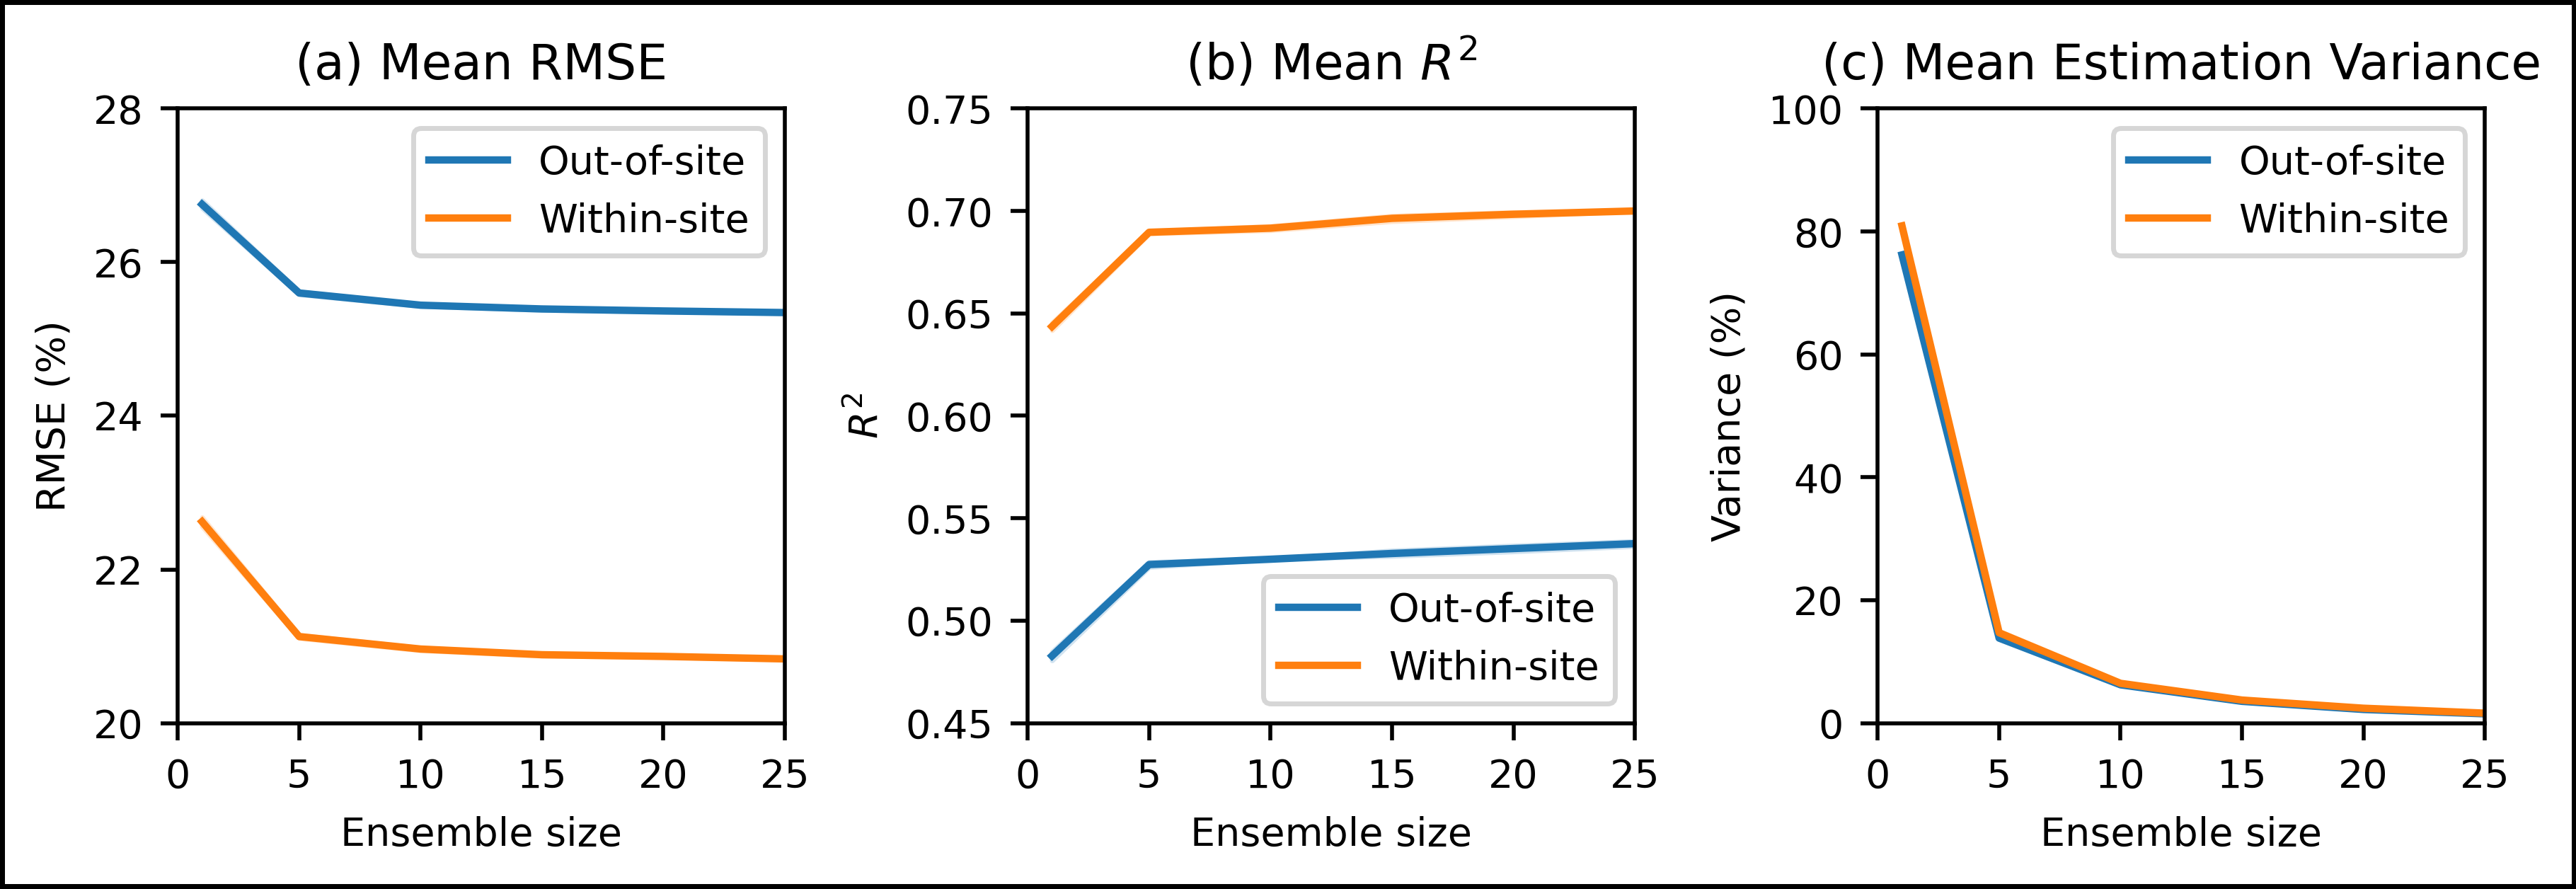

In [8]:
font_size = 8
plt.rcParams.update({'font.size': font_size})
fig = plt.figure(constrained_layout=False, figsize=(8.413, 2.3), dpi=500, linewidth=2, edgecolor="black")

# RMSE plot
plt.subplot(131)
data1_ = pd.DataFrame({common.ENSEMBLE_SIZES[n]: stats_.RMSE for n, stats_ in enumerate(all_stats1)}).melt(
    var_name='Ensemble size', value_name = 'RMSE')
data1_['model'] = SCENARIOS[0].capitalize()
data2_ = pd.DataFrame({common.ENSEMBLE_SIZES[n]: stats_.RMSE for n, stats_ in enumerate(all_stats2)}).melt(
    var_name='Ensemble size', value_name = 'RMSE')
data2_['model'] = SCENARIOS[1].capitalize()
data_ = pd.concat([data1_, data2_]).reset_index()
plt.ylim(20, 28)
plt.xlim(0, 25)
plt.xticks(np.arange(0, 30, 5))
ax = sns.lineplot(x='Ensemble size', y='RMSE', hue='model', data=data_)
plt.title('(a) Mean RMSE', size=10)
plt.ylabel('RMSE (%)')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)

# R2 plot
plt.subplot(132)
data1_ = pd.DataFrame({common.ENSEMBLE_SIZES[n]: stats_.R2 for n, stats_ in enumerate(all_stats1)}).melt(
    var_name='Ensemble size', value_name = 'R2')
data1_['model'] = SCENARIOS[0].capitalize()
data2_ = pd.DataFrame({common.ENSEMBLE_SIZES[n]: stats_.R2 for n, stats_ in enumerate(all_stats2)}).melt(
    var_name='Ensemble size', value_name = 'R2')
data2_['model'] = SCENARIOS[1].capitalize()
data_ = pd.concat([data1_, data2_]).reset_index(drop=True)
ax = sns.lineplot(x='Ensemble size', y='R2', hue='model', data=data_)
plt.title('(b) Mean $R^2$', size=10)
plt.ylim(0.45, 0.75)
plt.xlim(0, 25)
plt.xticks(np.arange(0, 30, 5))
plt.ylabel('$R^2$')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)

# Variance plot
plt.subplot(133)
data1_ = pd.DataFrame(ci_df1, index=common.ENSEMBLE_NAMES)
data1_['model'] = SCENARIOS[0].capitalize()
data1_['Ensemble size'] = common.ENSEMBLE_SIZES
data2_ = pd.DataFrame(ci_df2, index=common.ENSEMBLE_NAMES)
data2_['model'] = SCENARIOS[1].capitalize()
data2_['Ensemble size'] = common.ENSEMBLE_SIZES
data_ = pd.concat([data1_, data2_]).reset_index(drop=True)
ax = sns.lineplot(x='Ensemble size', y='Pred_var', hue='model', data=data_)
plt.title('(c) Mean Estimation Variance', size=10)
plt.ylim(0, 100)
plt.xlim(0, 25)
plt.xticks(np.arange(0, 30, 5))
plt.ylabel('Variance (%)')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)

plt.subplots_adjust(wspace=0.4)
fig.savefig(os.path.join(common.FIGURES_DIR, 'Ensemble sizes.jpeg'), format="jpeg", bbox_inches='tight', pad_inches=0.2, dpi=500)